In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
from functions.inequality import gini, lorenz_curve
from qe_inequality_model import *
import statsmodels.api as sm
from matplotlib import style
import scipy.stats as stats
from statsmodels.iolib.summary2 import summary_col
from functions.find_bubbles import *

In [2]:
style.use('seaborn-ticks')

In [3]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# No QE model dynamics

In [34]:
NRUNS = 5
burn_in_period = 0

In [35]:
# # 1 setup parameters
params_nb = {"fundamental_values": [105, 166], "asset_types": ['stock', 'stock'],
              "trader_sample_size": 22, "n_traders": 500,
              "ticks": 800, "std_fundamentals": [0.02, 0.053],
              "std_noise": 0.159, "w_random": 0.056,
              "strat_share_chartists": 0.40,
              "init_assets": [1662, 571], "base_risk_aversion": 4.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 2.22,
              "trades_per_tick": 3, "mutation_intensity": 0.0477,
              "average_learning_ability": 0.038, 'money_multiplier': 0.7,
              "bond_mean_reversion": 0.0, 'cb_pf_range': 0.1,
              "qe_perc_size": 0.20, "cb_size": 0.02, "qe_asset_index": 0}

In [36]:
trdrs_nb = []
orbs_nb = []
central_banks_nb = []

for seed_nb in range(NRUNS): 
    traders_nb, central_bank_nb, orderbook_nb = init_objects_active_cb(params_nb, seed_nb)
    traders_nb, central_bank_nb, orderbook_nb = qe_ineq_active_cb_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=None,seed=seed_nb)
    central_banks_nb.append(central_bank_nb)
    trdrs_nb.append(traders_nb)
    orbs_nb.append(orderbook_nb)

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
4

633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882


In [37]:
asset_prices_nb = []
asset_fundamentals_nb = []
asset_volumes_nb = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs_nb[run][idx].tick_close_price for run in range(NRUNS)]).transpose()
    asset_prices_nb.append(ap)
    
    fn = pd.DataFrame([orbs_nb[run][idx].fundamental for run in range(NRUNS)]).transpose()
    asset_fundamentals_nb.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs_nb[run][0].transaction_volumes_history] for run in range(NRUNS)]).transpose()
    asset_volumes_nb.append(av)

Text(0, 0.5, 'Volume')

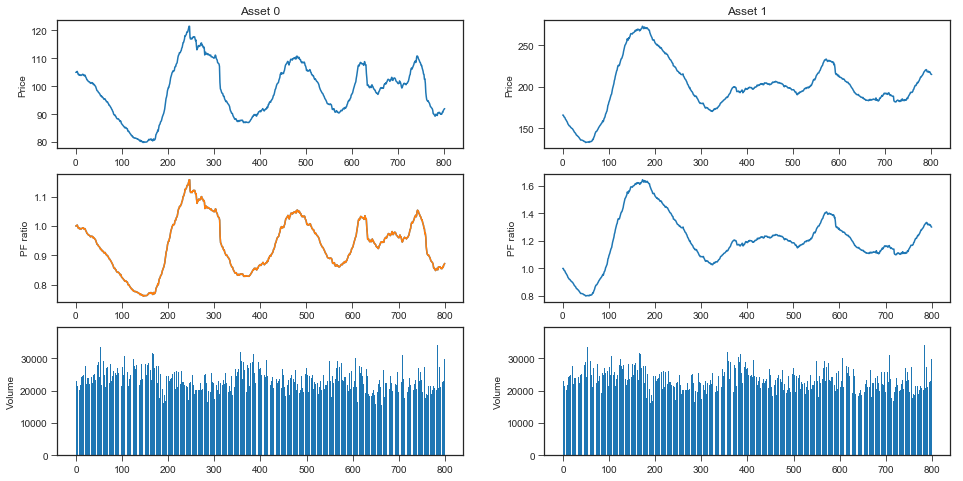

In [38]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(asset_prices_nb[0].index, asset_prices_nb[0].mean(axis=1))
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(asset_prices_nb[1].index, asset_prices_nb[1].mean(axis=1))
ax2.set_ylabel('Price')

# pd ratio's 
ax3.plot(asset_prices_nb[0].index, asset_prices_nb[0].mean(axis=1) / asset_fundamentals_nb[0].mean(axis=1))
ax3.plot(asset_prices_nb[0].index, asset_prices_nb[0].mean(axis=1) / asset_fundamentals_nb[0].mean(axis=1))
ax3.set_ylabel('PF ratio')

ax4.plot(asset_prices_nb[1].index, asset_prices_nb[1].mean(axis=1) / asset_fundamentals_nb[1].mean(axis=1))
ax4.set_ylabel('PF ratio')

# volumes
ax5.bar(asset_volumes_nb[0].index, asset_volumes_nb[0].mean(axis=1))
ax5.set_ylabel('Volume')

ax6.bar(asset_volumes_nb[1].index, asset_volumes_nb[0].mean(axis=1))
ax6.set_ylabel('Volume')


# QE Bust

In [46]:
# # 1 setup parameters
params = {"fundamental_values": [105, 166], "asset_types": ['stock', 'stock'],
              "trader_sample_size": 22, "n_traders": 500,
              "ticks": 800, "std_fundamentals": [0.02, 0.053],
              "std_noise": 0.159, "w_random": 0.056,
              "strat_share_chartists": 0.40,
              "init_assets": [1662, 571], "base_risk_aversion": 4.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 2.22,
              "trades_per_tick": 3, "mutation_intensity": 0.0477,
              "average_learning_ability": 0.038, 'money_multiplier': 0.7,
              "bond_mean_reversion": 0.0, 'cb_pf_range': 0.1,
              "qe_perc_size": 0.20, "cb_size": 0.02, "qe_asset_index": 0}

In [47]:
trdrs = []
orbs = []
central_banks = []

for seed in range(NRUNS): 
    traders, central_bank, orderbook = init_objects_active_cb(params, seed)
    traders, central_bank, orderbook = qe_ineq_active_cb_model(traders, central_bank, orderbook, params, scenario='BUSTQE', seed=seed)
    central_banks.append(central_bank)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
4

633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882


## Prices and volumes

In [48]:
asset_prices_QEBUST = []
asset_fundamentals_QEBUST = []
asset_volumes_QEBUST = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS)]).transpose()
    asset_prices_QEBUST.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS)]).transpose()
    asset_fundamentals_QEBUST.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][0].transaction_volumes_history] for run in range(NRUNS)]).transpose()
    asset_volumes_QEBUST.append(av)

Text(0, 0.5, 'PF ratio')

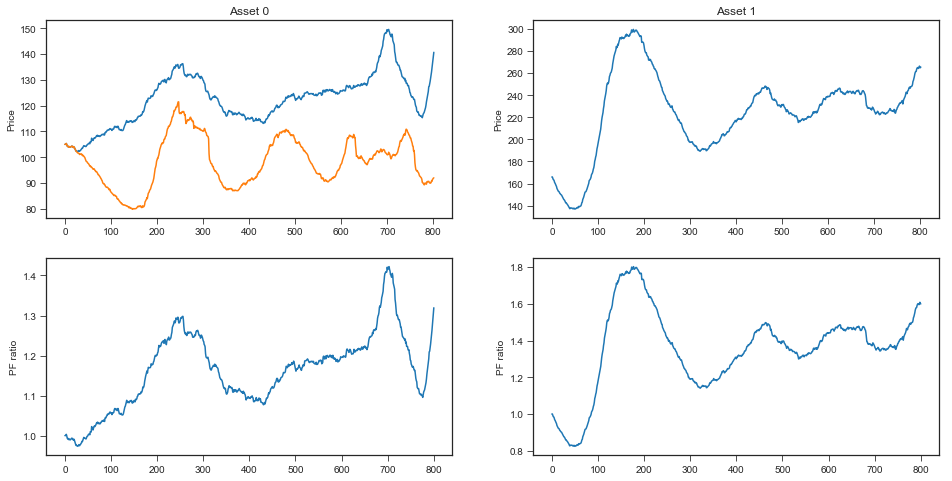

In [49]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(asset_prices_QEBUST[0].index, asset_prices_QEBUST[0].mean(axis=1))
ax1.plot(asset_prices_nb[0].index, asset_prices_nb[0].mean(axis=1))
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(asset_prices_QEBUST[1].index, asset_prices_QEBUST[1].mean(axis=1))
ax2.set_ylabel('Price')

# pd ratio's 
ax3.plot(asset_prices_QEBUST[0].index, asset_prices_QEBUST[0].mean(axis=1) / asset_fundamentals_QEBUST[0].mean(axis=1))
ax3.set_ylabel('PF ratio')

ax4.plot(asset_prices_QEBUST[1].index, asset_prices_QEBUST[1].mean(axis=1) / asset_fundamentals_QEBUST[1].mean(axis=1))
ax4.set_ylabel('PF ratio')

# # volumes
# ax5.bar(asset_volumes[0].index, asset_volumes[0].mean(axis=1))
# ax5.set_ylabel('Volume')

# ax6.bar(asset_volumes[1].index, asset_volumes[0].mean(axis=1))
# ax6.set_ylabel('Volume')


# QT Bust

In [ ]:
trdrs = []
orbs = []
central_banks = []

for seed in range(NRUNS): 
    traders, central_bank, orderbook = init_objects_active_cb(params, seed)
    traders, central_bank, orderbook = qe_ineq_active_cb_model(traders, central_bank, orderbook, params, scenario='QTBUST', seed=seed)
    central_banks.append(central_bank)
    trdrs.append(traders)
    orbs.append(orderbook)

## Prices and volumes

In [ ]:
asset_prices_QTBUST = []
asset_fundamentals_QTBUST = []
asset_volumes_QTBUST = []

for idx, a in enumerate(params['asset_types']):
    ap = pd.DataFrame([orbs[run][idx].tick_close_price for run in range(NRUNS)]).transpose()
    asset_prices_QTBUST.append(ap)
    
    fn = pd.DataFrame([orbs[run][idx].fundamental for run in range(NRUNS)]).transpose()
    asset_fundamentals_QTBUST.append(fn)
    
    av = pd.DataFrame([[sum(v) for v in orbs[run][0].transaction_volumes_history] for run in range(NRUNS)]).transpose()
    asset_volumes_QTBUST.append(av)

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,8))

# prices
ax1.set_title('Asset 0')
ax1.plot(asset_prices_QTBUST[0].index, asset_prices_QEBUST[0].mean(axis=1))
ax1.set_ylabel('Price')

ax2.set_title('Asset 1')
ax2.plot(asset_prices_QTBUST[1].index, asset_prices_QEBUST[1].mean(axis=1))
ax2.set_ylabel('Price')

# pd ratio's 
ax3.plot(asset_prices_QTBUST[0].index, asset_prices_QEBUST[0].mean(axis=1) / asset_fundamentals_QEBUST[0].mean(axis=1))
ax3.set_ylabel('PF ratio')

ax4.plot(asset_prices[1].index, asset_prices_QEBUST[1].mean(axis=1) / asset_fundamentals_QEBUST[1].mean(axis=1))
ax4.set_ylabel('PF ratio')

# # volumes
# ax5.bar(asset_volumes[0].index, asset_volumes[0].mean(axis=1))
# ax5.set_ylabel('Volume')

# ax6.bar(asset_volumes[1].index, asset_volumes[0].mean(axis=1))
# ax6.set_ylabel('Volume')


## No buyer of last resort

In [16]:
# # 1 setup parameters
params_nb = {"fundamental_values": [105, 166], "asset_types": ['stock', 'stock'],
              "trader_sample_size": 22, "n_traders": 500,
              "ticks": 800, "std_fundamentals": [0.02, 0.053],
              "std_noise": 0.159, "w_random": 0.056,
              "strat_share_chartists": 0.41,
              "init_assets": [1662, 571], "base_risk_aversion": 3.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 2.2,
              "trades_per_tick": 3, "mutation_intensity": 0.0477,
              "average_learning_ability": 0.06, 'money_multiplier': 0.7,
              "bond_mean_reversion": 0.0, 'cb_pf_range': 0.2,
              "qe_perc_size": 0.0, "cb_size": 0.0, "qe_asset_index": 0}

## Compare scenario's

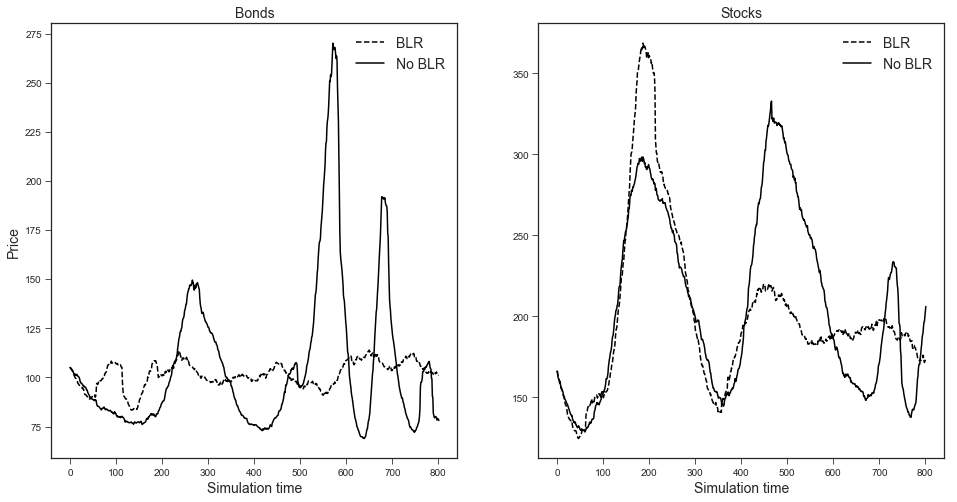

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))


ax1.set_title('Bonds', fontsize='14')
ax1.plot(asset_prices[0].index, asset_prices[0].mean(axis=1), 'k--', label='BLR')
ax1.plot(asset_prices_nb[0].index, asset_prices_nb[0].mean(axis=1), 'k-', label='No BLR')
ax1.set_ylabel('Price', fontsize='14')
ax1.legend(loc='best', fontsize='14')

ax2.set_title('Stocks', fontsize='14')
ax2.plot(asset_prices[1].index, asset_prices[1].mean(axis=1), 'k--', label='BLR')
ax2.plot(asset_prices_nb[1].index, asset_prices_nb[1].mean(axis=1), 'k-', label='No BLR')
#ax2.set_ylabel('Price')
ax2.legend(loc='best', fontsize='14')

for ax in [ax1, ax2]:
    ax.set_xlabel('Simulation time', fontsize='14')

fig.savefig('buyer_of_last_resort.png')

## Compare stdev_price